In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob 
import os
import json
import re

In [2]:
def get_frame_id(path):
    path = os.path.basename(path)
    return re.findall(r'[0-9][0-9][0-9][0-9][0-9]',path)[0]

In [3]:
valid_set = [get_frame_id(path) for path in sorted(list(glob.glob('/mnt/home/tchan1/ceph/preped-npy/valid-out/*rhop.npy')))]

In [4]:
valid_set[:10]

['00001',
 '00004',
 '00009',
 '00012',
 '00017',
 '00022',
 '00030',
 '00034',
 '00050',
 '00051']

In [5]:
def format_json(json, formatter):
    for key, val in json.items():
        if key in formatter.keys():
            json[key] = formatter[key](val)
    return json

In [6]:
def get_valid_rdf(path,valid_set):
    path = sorted(list(glob.glob(path)))[0]
    with open(path,'r') as json_file:
        #print(json.load(json_file))
        valid_subset = [frame for frame in json.load(json_file) if get_frame_id(frame['rho-path']) in valid_set]
        for entry in valid_subset:
            formatter = {
                        'binEdges':np.array,
                        'binCenters':np.array,
                        'DCF': np.array,
                        'RDF': np.array
                    }
            format_json(entry,formatter)
    return valid_subset


In [7]:
def get_valid_vrel(path, valid_set):
    paths = sorted(list(glob.glob(path)))
    #print(paths)
    vrel_list = []
    for path in paths:
        with open(path,'r') as json_file:
            frame = json.load(json_file)
            if get_frame_id(frame['rhop-path']) in valid_set:
                formatter = {
                    'binEdges':np.array,
                    'binCenters':np.array,
                    'velc_sum': np.array,
                    'velc_rad_sum': np.array
                }
                format_json(frame,formatter)
                vrel_list.append(frame)
    return vrel_list

In [8]:
def get_rdf_fluctuation(rdf_list,list_mode=False,with_qunatiles=False):
    assert len(rdf_list) >= 1
    rdf_items = []
    for rdf in rdf_list:
        rdf_items.append(rdf['RDF'])
    stacked_rdf = np.stack(rdf_items)
    rdf_mean = np.median(stacked_rdf,axis=0)
    rdf_var  = np.var(stacked_rdf,axis=0)
    q1,q3 = np.quantile(stacked_rdf,[0.05,0.95],axis=0)
    binCenters = [rdf['binCenters']]*len(rdf_items) if list_mode else rdf['binCenters']
    
    return {
        'binCenters':binCenters,
        'items': rdf_items,
        'mean': rdf_mean,
        'var': rdf_var,
        'q1':q1,
        'q3':q3
    }

In [9]:
def get_velc_fluctuation(velc_list, list_mode=False):
    assert len(velc_list) >= 1
    velc_items = []
    rad_items  = []
    for velc in velc_list:
        velc_items.append(velc['velc_sum'])
        rad_items.append(velc['velc_rad_sum'])
    stacked_velc = np.stack(velc_items)
    stacked_rad  = np.stack(rad_items)
    velc_median  = np.median(stacked_velc,axis=0)
    rad_median   = np.median(stacked_rad, axis=0)
    velc_var     = np.var(stacked_velc,axis=0)
    rad_var      = np.var(stacked_rad, axis=0)
    velc_q1, velc_q3 = np.quantile(stacked_velc,[0.05,0.95],axis=0)
    rad_q1,  rad_q3  = np.quantile(stacked_rad, [0.05,0.95],axis=0)
    binCenters = [velc['binCenters']]*len(velc_items) if list_mode else velc['binCenters']
    
    return {
        'binCenters':binCenters,
        'velc_items': velc_items,
        'rad_items': rad_items,
        'velc_mean': velc_median,
        'rad_mean': rad_median,
        'velc_var': velc_var,
        'rad_var': rad_var,
        'velc_q1': velc_q1, 'velc_q3':velc_q3,
        'rad_q1' : rad_q1,  'rad_q3': rad_q3
    }
    

In [10]:
def get_rdf_ratio_fluctuation(tgt_rdfs, out_rdfs):
    sorted_tgt = sorted(tgt_rdfs,key=lambda d: d['rho-path'])
    sorted_out = sorted(out_rdfs,key=lambda d: d['rho-path'])
    tgt_rdfs = [frame['RDF'] for frame in sorted_tgt]
    out_rdfs = [frame['RDF'] for frame in sorted_out]
    stack_tgt = np.stack(tgt_rdfs)
    stack_out = np.stack(out_rdfs)
    
    stack_ratio = stack_out/stack_tgt
    ratio_median = np.median(stack_ratio, axis=0)
    ratio_var    = np.var(stack_ratio,axis=0)
    ratio_q1, ratio_q3 = np.quantile(stack_ratio,[0.05,0.95],axis=0)
    
    return {
        'binCenters':sorted_tgt[0]['binCenters'],
        'ratio_mean': ratio_median,
        'ratio_q1':ratio_q1,
        'ratio_q3':ratio_q3
    }

In [11]:
def get_vel_ratio_fluctuation(tgt_vrel,out_vrel):
    sorted_tgt = sorted(tgt_vrel,key=lambda d: d['rhop-path'])
    sorted_out = sorted(out_vrel,key=lambda d: d['rhop-path'])
    
    tgt_vel = [frame['velc_sum'] for frame in sorted_tgt]
    out_vel = [frame['velc_sum'] for frame in sorted_out]
    tgt_rad = [frame['velc_rad_sum'] for frame in sorted_tgt]
    out_rad = [frame['velc_rad_sum'] for frame in sorted_out]
    
    stack_tgt_vel = np.stack(tgt_vel)
    stack_out_vel = np.stack(out_vel)
    stack_tgt_rad = np.stack(tgt_rad)
    stack_out_rad = np.stack(out_rad)
    
    stack_ratio_vel = stack_out_vel/stack_tgt_vel
    stack_ratio_rad = stack_out_rad/stack_tgt_rad
    
    vel_median = np.median(stack_ratio_vel, axis=0)
    rad_median = np.median(stack_ratio_rad, axis=0)
    
    vel_q1, vel_q3 = np.quantile(stack_ratio_vel,[0.05,0.95],axis=0)
    rad_q1, rad_q3 = np.quantile(stack_ratio_rad,[0.05,0.95],axis=0)
    
    return {
        'binCenters':sorted_tgt[0]['binCenters'],
        'vel_mean': vel_median,
        'rad_mean': rad_median,
        'vel_q1':vel_q1,'vel_q3':vel_q3,
        'rad_q1':rad_q1,'rad_q3':rad_q3
    }
    

In [12]:
valid_tgt_rdfs = get_valid_rdf('tgt-normal*.json',valid_set)
valid_out_rdfs = get_valid_rdf('out-longer3-1646320938.json',valid_set)
valid_tgt_vrel = get_valid_vrel('/mnt/home/tchan1/ceph/grid-stats/tgt-normal/*.json',valid_set)
valid_out_vrel = get_valid_vrel('/mnt/home/tchan1/ceph/grid-stats/out-longer3/grid-stat-normal-*.json',valid_set)

In [13]:
valid_tgt_vrel  = [frame for frame in valid_tgt_vrel if get_frame_id(frame['rhop-path']) != '00009']
valid_out_vrel = [frame for frame in valid_out_vrel if get_frame_id(frame['rhop-path']) != '00009']

In [14]:
len(valid_tgt_vrel ), len(valid_out_vrel )

(49, 49)

In [15]:
rdf_tgt = get_rdf_fluctuation(valid_tgt_rdfs)
rdf_out = get_rdf_fluctuation(valid_out_rdfs)
vel_tgt = get_velc_fluctuation(valid_tgt_vrel)
vel_out = get_velc_fluctuation(valid_out_vrel)
rdf_ratio   = get_rdf_ratio_fluctuation(valid_tgt_rdfs,valid_out_rdfs)
vel_ratio   = get_vel_ratio_fluctuation(valid_tgt_vrel,valid_out_vrel)

In [16]:
from matplotlib.backends.backend_pdf import PdfPages

In [17]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": ["Helvetica"]})

In [18]:
mycolors = ['#785EF0', '#DC267F', '#FFB000']

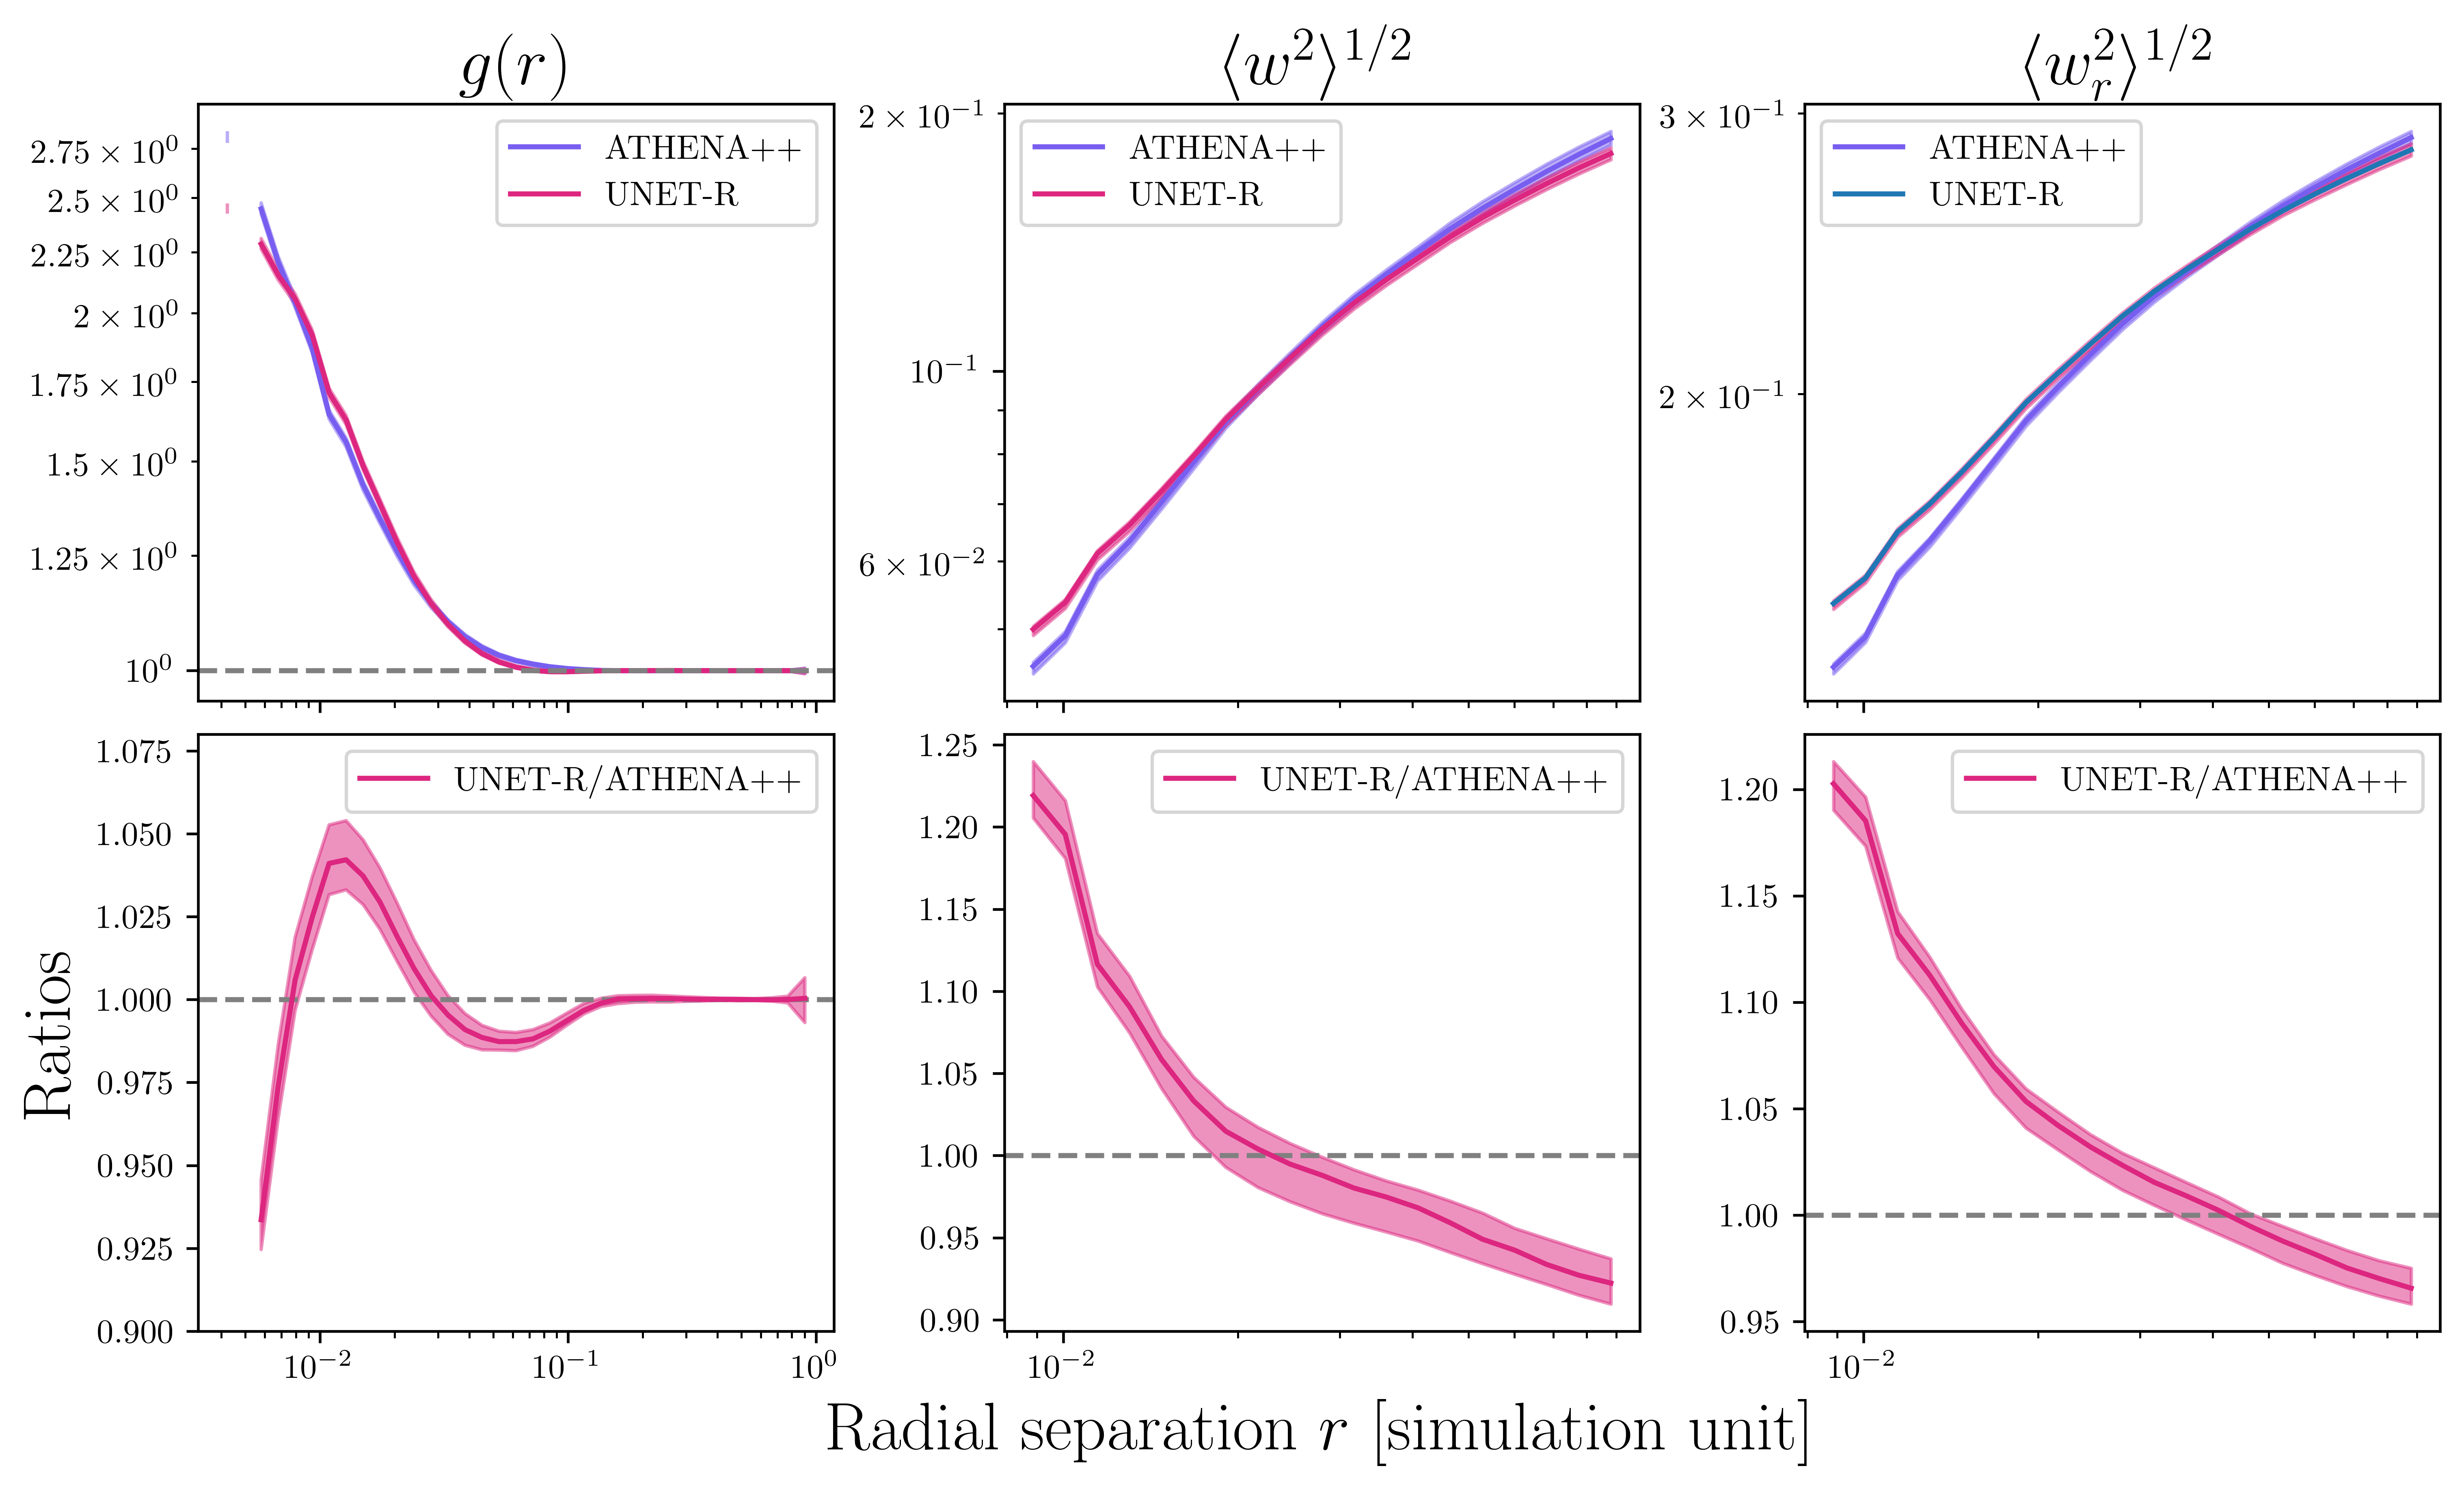

In [21]:
with PdfPages('normal_consistency.pdf') as pdf:
    fig, axs = plt.subplots(nrows=2,ncols=3,constrained_layout=True,sharex='col',figsize=(10,6),dpi=600)
    
    """RDF Plots"""
    axs[0][0].plot(rdf_tgt['binCenters'], rdf_tgt['mean'],label='ATHENA++',color=mycolors[0])
    axs[0][0].fill_between(rdf_tgt['binCenters'],rdf_tgt['q1'],rdf_tgt['q3'],alpha=0.5,color=mycolors[0])

    axs[0][0].plot(rdf_out['binCenters'], rdf_out['mean'],label='UNET-R',color=mycolors[1])
    axs[0][0].fill_between(rdf_out['binCenters'],rdf_out['q1'],rdf_out['q3'],alpha=0.5,color=mycolors[1])
    axs[0][0].axhline(y=1.0,color='grey',ls='--')
    axs[0][0].legend()

    axs[0][0].set_yscale('log')
    axs[0][0].set_xscale('log')

    #axs[1][0].plot(rdf_tgt['binCenters'], rdf_tgt['mean'])
    axs[1][0].axhline(y=1.0,color='grey',ls='--')
    axs[1][0].set_ylim(0.9,1.08)
    axs[1][0].plot(rdf_ratio['binCenters'],rdf_ratio['ratio_mean'],label='UNET-R/ATHENA++',color=mycolors[1])
    axs[1][0].fill_between(rdf_ratio['binCenters'],rdf_ratio['ratio_q1'],rdf_ratio['ratio_q3'],alpha=0.5,color=mycolors[1])
    axs[1][0].legend()

    """Relative velocity plots"""
    axs[0][1].plot(vel_tgt['binCenters'],np.sqrt(vel_tgt['velc_mean']),label='ATHENA++',color=mycolors[0])
    axs[0][1].fill_between(vel_tgt['binCenters'],np.sqrt(vel_tgt['velc_q1']),np.sqrt(vel_tgt['velc_q3']),alpha=0.5,color=mycolors[0])
    axs[0][1].plot(vel_out['binCenters'],np.sqrt(vel_out['velc_mean']),label='UNET-R',color=mycolors[1])
    axs[0][1].fill_between(vel_out['binCenters'],np.sqrt(vel_out['velc_q1']),np.sqrt(vel_out['velc_q3']),alpha=0.5,color=mycolors[1])
    axs[0][1].legend()
    axs[0][1].set_yscale('log')
    axs[0][1].set_xscale('log')

    axs[1][1].axhline(y=1.0,color='grey',ls='--')
    axs[1][1].plot(vel_ratio['binCenters'],vel_ratio['vel_mean'],label='UNET-R/ATHENA++',color=mycolors[1])
    axs[1][1].fill_between(vel_ratio['binCenters'],vel_ratio['vel_q1'],vel_ratio['vel_q3'],alpha=0.5,color=mycolors[1])
    
    """axs[1][1].fill_between(vel_tgt['binCenters'],np.sqrt(vel_tgt['velc_q1']/vel_tgt['velc_mean']),np.sqrt(vel_tgt['velc_q3']/vel_tgt['velc_mean']),alpha=0.5)

    axs[1][1].plot(vel_out['binCenters'],np.sqrt(vel_out['velc_mean']/vel_tgt['velc_mean']),color='tab:orange',label='UNET-R/ATHENA++')
    axs[1][1].fill_between(vel_out['binCenters'],np.sqrt(vel_out['velc_q1']/vel_tgt['velc_mean']),np.sqrt(vel_out['velc_q3']/vel_tgt['velc_mean']),alpha=0.5)
    """
    axs[1][1].legend()
    
    """Relative radial velocity plots"""
    axs[0][2].plot(vel_tgt['binCenters'],np.sqrt(vel_tgt['rad_mean']),label='ATHENA++',color=mycolors[0])
    axs[0][2].fill_between(vel_tgt['binCenters'],np.sqrt(vel_tgt['rad_q1']),np.sqrt(vel_tgt['rad_q3']),alpha=0.5,color=mycolors[0])
    axs[0][2].plot(vel_out['binCenters'],np.sqrt(vel_out['rad_mean']),label='UNET-R')
    axs[0][2].fill_between(vel_out['binCenters'],np.sqrt(vel_out['rad_q1']),np.sqrt(vel_out['rad_q3']),alpha=0.5,color=mycolors[1])
    axs[0][2].legend()
    axs[0][2].set_yscale('log')
    axs[0][2].set_xscale('log')
    
    
    axs[1][2].axhline(y=1.0,color='grey',ls='--')
    axs[1][2].plot(vel_ratio['binCenters'],vel_ratio['rad_mean'],label='UNET-R/ATHENA++',color=mycolors[1])
    axs[1][2].fill_between(vel_ratio['binCenters'],vel_ratio['rad_q1'],vel_ratio['rad_q3'],alpha=0.5,color=mycolors[1])
    """axs[1][2].fill_between(vel_tgt['binCenters'],np.sqrt(vel_tgt['rad_q1']/vel_tgt['rad_mean']),np.sqrt(vel_tgt['rad_q3']/vel_tgt['rad_mean']),alpha=0.5)

    axs[1][2].plot(vel_out['binCenters'],np.sqrt(vel_out['rad_mean']/vel_tgt['rad_mean']),color='tab:orange',label='UNET-R/ATHENA++')
    axs[1][2].fill_between(vel_out['binCenters'],np.sqrt(vel_out['rad_q1']/vel_tgt['rad_mean']),np.sqrt(vel_out['rad_q3']/vel_tgt['rad_mean']),alpha=0.5)
    """
    axs[1][2].legend()

    axs[0][0].set_title(r'$g(r)$',fontsize=20)
    #axs[1][0].set_xlabel(r'Radial separation $r$ [simulation unit]',fontsize=20)
    axs[1][0].set_ylabel(r'Ratios',fontsize=20)

    axs[0][1].set_title(r'$\langle w^2\rangle^{1/2}$',fontsize=20)
    axs[1][1].set_xlabel(r'Radial separation $r$ [simulation unit]',fontsize=20)
    #axs[1][1].set_ylabel(r'Ratio of relative particle velocity')

    axs[0][2].set_title(r'$\langle w^2_r\rangle^{1/2}$',fontsize=20)
    #axs[1][2].set_xlabel(r'Radial separation $r$ [simulation unit]',fontsize=20)
    #axs[1][2].set_ylabel(r'Ratio of relative radial particle velocity')

    #axs[0][1].set_title('Particle statistics of normal validation set\n',fontsize=14)
    
    pdf.savefig(fig)

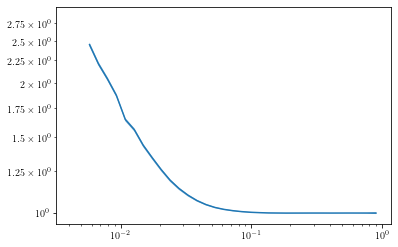

In [19]:
plt.plot(rdf_tgt['binCenters'], rdf_tgt['mean'])
plt.fill_between(rdf_tgt['binCenters'],rdf_tgt['q1'],rdf_tgt['q3'],alpha=0.5)
plt.yscale('log')
plt.xscale('log')